Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

Load The Dataset


In [ ]:
# Directories
image_data_dir = "/content/drive/MyDrive/WeedCrop.v1i.yolov5pytorch/test/images"
labels_data_dir = "/content/drive/MyDrive/WeedCrop.v1i.yolov5pytorch/test/labels"

# Get image filenames
image_filenames = os.listdir(image_data_dir)
image_data = []
labels = []

# Desired image dimensions
target_width = 128  # Example width
target_height = 128 # Example height

# Iterate through image files and load corresponding label files
for filename in image_filenames:
    image_path = os.path.join(image_data_dir, filename)
    image = cv2.imread(image_path)

    # Resize the image
    image = cv2.resize(image, (target_width, target_height))

    image_data.append(image)

    # Construct the path to the corresponding label file
    label_filename = os.path.splitext(filename)[0] + ".txt"
    label_path = os.path.join(labels_data_dir, label_filename)

    # Check if the label file exists
    if os.path.exists(label_path):
        # Read the label file
        with open(label_path, 'r') as file:
            bounding_boxes = file.readlines()

        # Convert the bounding boxes to a structured format
        image_labels = []
        for box in bounding_boxes:
            box_data = list(map(float, box.strip().split()[1:]))  # Ignore the first column (class ID)
            image_labels.append(box_data)  # Add the bounding box coordinates

        labels.append(image_labels)
    else:
        print(f"Warning: Label file not found for {filename}. Skipping this image.")
        image_data.pop()  # Remove the corresponding image data since no label file exists

# Convert to NumPy arrays
image_data = np.array(image_data)


# One-hot encoding can be skipped since bounding boxes are used, not class labels
# If you had class labels, you would do:
# y = to_categorical(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)


Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)


Design CNN Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class WeedDetectionCNN(nn.Module):
    def __init__(self):
        super(WeedDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        # Calculate the correct input features for fc1:
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Adjusted input features
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Assuming 2 classes for weed detection

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Instantiate the model
model = WeedDetectionCNN()


In [ ]:
import torch.optim as optim
model = WeedDetectionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Set Loss Function and Optimizer

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the Model

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have your data in NumPy arrays X_train, X_test, y_train, y_test
# If not, you need to load your data first
# Example using placeholder data:
import numpy as np

# Replace these with your actual data loading and preprocessing
X_train = np.random.rand(100, 64, 64, 3)  # Example: 100 images of size 64x64 with 3 channels
X_test = np.random.rand(20, 64, 64, 3)    # Example: 20 images for testing
y_train = np.random.randint(0, 2, 100)    # Example: 100 labels (0 or 1)
y_test = np.random.randint(0, 2, 20)     # Example: 20 labels for testing

# Check if GPU is available and use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train).permute(0, 3, 1, 2)  # Rearrange to (batch_size, channels, height, width)
X_test_tensor = torch.Tensor(X_test).permute(0, 3, 1, 2)
y_train_tensor = torch.Tensor(y_train).long()
y_test_tensor = torch.Tensor(y_test).long()



# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy - Changed line
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() # Comparing predicted labels directly with target labels

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%")

# Validation loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        # Comparing predicted labels directly with target labels
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")


Epoch 1/100, Loss: 0.6930220574140549, Accuracy: 51.0%
Epoch 2/100, Loss: 0.6939713656902313, Accuracy: 45.0%
Epoch 3/100, Loss: 0.6860446482896805, Accuracy: 48.0%
Epoch 4/100, Loss: 0.7143379151821136, Accuracy: 48.0%
Epoch 5/100, Loss: 0.6999890059232712, Accuracy: 50.0%
Epoch 6/100, Loss: 0.6918964385986328, Accuracy: 56.0%
Epoch 7/100, Loss: 0.6928972452878952, Accuracy: 48.0%
Epoch 8/100, Loss: 0.6913574039936066, Accuracy: 51.0%
Epoch 9/100, Loss: 0.6914938539266586, Accuracy: 52.0%
Epoch 10/100, Loss: 0.6974755376577377, Accuracy: 52.0%
Epoch 11/100, Loss: 0.6939943879842758, Accuracy: 52.0%
Epoch 12/100, Loss: 0.6884345412254333, Accuracy: 52.0%
Epoch 13/100, Loss: 0.6957956105470657, Accuracy: 52.0%
Epoch 14/100, Loss: 0.6877295225858688, Accuracy: 52.0%
Epoch 15/100, Loss: 0.6892547756433487, Accuracy: 52.0%
Epoch 16/100, Loss: 0.6940195560455322, Accuracy: 52.0%
Epoch 17/100, Loss: 0.6856259107589722, Accuracy: 63.0%
Epoch 18/100, Loss: 0.6842655390501022, Accuracy: 59.0%
E

Evaluate the model

In [ ]:
import torch

def evaluate(model, test_loader, device):
  """
  Evaluates the model on the test data.

  Args:
      model: The PyTorch model to evaluate.
      test_loader: The DataLoader for the test data.
      device: The device to run the evaluation on (e.g., 'cuda' or 'cpu').

  Returns:
      A tuple containing the test loss and test accuracy.
  """
  model.eval()  # Set the model to evaluation mode
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        # Comparing predicted labels directly with target labels
        correct += (predicted == labels).sum().item()
        loss += criterion(outputs, labels).item() # Calculate the loss for this batch

  # Calculate average loss and accuracy
  avg_loss = loss / len(test_loader)
  accuracy = 100 * correct / total

  return avg_loss, accuracy

# Assuming you have your model, test_loader, and device defined

# Evaluate the model
test_loss, test_accuracy = evaluate(model, test_loader, device)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Test loss: 1.24140202999115
Test accuracy: 50.0


Prediction

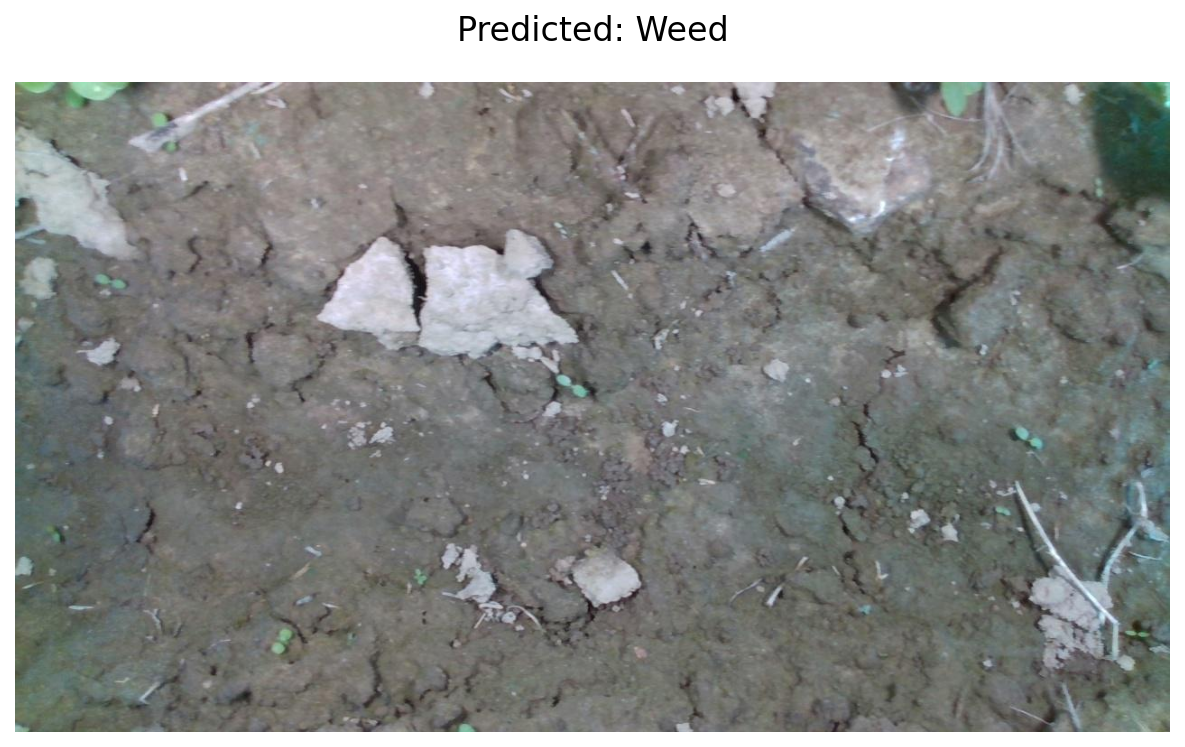

Actual class: Weed
Predicted class: Weed


In [11]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import torch
import os

# Assuming the model, device, and X_test, y_test are already defined elsewhere in your code

# Function to preprocess a single image
def preprocess_image(image, size=(64, 64)):
    # Resize the image
    resized_image = cv2.resize(image, size)
    # Convert image to float32 for better handling
    resized_image = resized_image.astype(np.float32) / 255.0
    # Normalize and convert the image to PyTorch tensor
    image_tensor = torch.Tensor(resized_image).permute(2, 0, 1).unsqueeze(0)  # (1, channels, height, width)
    return image_tensor

# Load the test image
# Get a list of image files in the directory
image_path = "/content/drive/MyDrive/WeedCrop.v1i.yolov5pytorch/test/images"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]

# Check if any image files were found
if not image_files:
    raise ValueError("No image files found in the directory.")

# Select a random image from the directory
random_image_file = random.choice(image_files)
test_image = cv2.imread(os.path.join(image_path, random_image_file))

# Ensure the image was loaded correctly
if test_image is None:
    raise ValueError("Image loading failed. Check the image path and file.")

# Test label for reference (modify as needed)
test_label = 1  # Assuming 'Weed' for testing, change according to your dataset

# Preprocess the image
test_image_tensor = preprocess_image(test_image).to(device)

# Set the model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(test_image_tensor)
    _, predicted_class = torch.max(output, 1)

predicted_class = predicted_class.item()

# Define a simple mapping for weed vs. non-weed classification
class_mapping = {0: "Non-Weed", 1: "Weed"}

# --- Display the Original Image with Adjustments for Clarity ---

# Ensure the image is in uint8 format for clear display
test_image_uint8 = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Create a figure with a higher DPI for better resolution
plt.figure(figsize=(8, 8), dpi=150)

# Display the original image and the predicted label
plt.imshow(test_image_uint8)
plt.title(f"Predicted: {class_mapping[predicted_class]}", fontsize=16, pad=20)
plt.axis('off')  # Remove axes for a cleaner look
plt.tight_layout()  # Ensure layout is clean with no title-image overlap
plt.show()

# Print actual class and prediction
print(f"Actual class: {class_mapping[test_label]}")
print(f"Predicted class: {class_mapping[predicted_class]}")
